# **Analysis of Configurations**

### **Frame complexity**

In [2]:
import skimage.measure   
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os


In [3]:
file = '../test_results/config_testing/resolution/'
stats = 'stats/'
column_order = ['Video', 'Width (px)', 'Height (px)', 'Frame Rate (fps)']
dfs = []

def get_average_size(df_path, x_res, y_res):
    average_size = 0
    df = pd.read_csv(df_path, index_col=0)
    
    for row in df.iterrows():
        average_size += (row[1][2] * row[1][3])
    
    average_size /= len(df)
    
    return average_size


for video in list(os.listdir(os.path.join(file, 'stats/'))):
    file_name = '_'.join(os.path.splitext(video)[0].split('_')[0:-1]) # Get file name
    stats = os.path.join(file, 'stats/', file_name + '_stats.txt')
    inference = os.path.join(file, 'inference/', file_name + '_inference.csv')
    energy = os.path.join(file, 'energy/', file_name + '_energy.csv')

    df = pd.read_csv(stats, \
            sep=': ', header=None, engine='python').set_index(0)
    df = df.transpose().reset_index(drop=True)

    config_params = os.path.basename(stats).split('_')
    
    if config_params[0] in ['large3', 'large5'] or int(config_params[3]) != 5:
        continue
    # if int(config_params[3]) == 25:
    #     continue
    
    # Setting columns based on params
    df['Video'] = f'{config_params[0]}'
    df['Width (px)'], df['Height (px)'], df['Frame Rate (fps)'] = \
    config_params[1], config_params[2], config_params[3]
    df = df.astype({'Width (px)': int, 'Height (px)': int})

    # Add columns
    df['Resolution (px)'] = df['Width (px)'].multiply(df['Height (px)'])
    df['Resolution (1000s of px)'] = df['Resolution (px)'] / 1000
    df['Energy (1000s of J)'] = df['energy'] / 1000
    df['Energy (J) per frame'] = df['energy'] / 250

    # Count # of detections
    with open(inference, 'r') as f:
        lines = f.readlines()
        df['Detections'] = len(lines) - 1  # subtract the first line, which is cols of df
    
    # Average object size
    df['Average detection size'] = get_average_size(inference, df['Width (px)'], df['Height (px)'])
                
    df = df.reindex(columns=column_order+[x for x in df.columns if x not in column_order])
    dfs.append(df)

out = pd.concat(dfs)

In [6]:
out

,Video,Width (px),Height (px),Frame Rate (fps),frames,frames processed,runtime (inference),average time per frame,runtime (total),energy,avg power,energy per frame,mAP,Resolution (px),Resolution (1000s of px),Energy (1000s of J),Energy (J) per frame,Detections,Average detection size
0,large4,640,360,5,250.0,51.0,29.783858,0.119135,48.488762,220.041639,4.537992,0.880167,0.294913,230400,230.4,0.220042,0.880167,249,76460.376065
0,large4,960,540,5,250.0,51.0,59.251097,0.237004,85.653778,405.774964,4.737385,1.623100,0.374657,518400,518.4,0.405775,1.623100,239,74546.314302
0,largeslow2,640,360,5,250.0,51.0,30.392390,0.121570,49.196264,219.821046,4.468247,0.879284,0.845565,230400,230.4,0.219821,0.879284,1202,39074.859600
0,largeslow2,960,540,5,250.0,51.0,60.199806,0.240799,79.839053,383.423995,4.802462,1.533696,0.675294,518400,518.4,0.383424,1.533696,1437,29317.369818
0,largeslow,640,360,5,250.0,51.0,30.710509,0.122842,49.631154,227.243875,4.578654,0.908976,0.645981,230400,230.4,0.227244,0.908976,627,53150.118581
0,largeslow,960,540,5,250.0,51.0,60.078842,0.240315,79.429527,395.138026,4.974699,1.580552,0.457577,518400,518.4,0.395138,1.580552,617,51589.930472
0,medium,640,360,5,250.0,51.0,30.615659,0.122463,49.363908,222.351504,4.504334,0.889406,0.196221,230400,230.4,0.222352,0.889406,476,8960.086469
0,medium,960,540,5,250.0,51.0,59.167163,0.236669,78.678620,383.355421,4.872422,1.533422,0.393059,518400,518.4,0.383355,1.533422,693,7211.095674
0,noisy,640,360,5,250.0,51.0,30.103794,0.120415,48.812983,217.214064,4.449924,0.868856,0.254916,230400,230.4,0.217214,0.868856,1600,6922.748259
0,noisy,960,540,5,250.0,51.0,60.292437,0.241170,89.746994,423.650884,4.720502,1.694604,0.353105,518400,518.4,0.423651,1.694604,2274,5703.441802


In [38]:
diff = pd.DataFrame()
for video in np.unique(out['Video']):
    sub = out.loc[out['Video'] == video]
    diff[video] = sub.loc[sub['Width (px)'] == 960]['mAP'] - sub.loc[sub['Width (px)'] == 640]['mAP'] 

diff = diff.transpose().reset_index()

In [39]:
diff

,index,0
0,large4,0.079743
1,largeslow,-0.188404
2,largeslow2,-0.170271
3,medium,0.196838
4,noisy,0.098189
5,smallslow2,0.086652
6,sparse,0.050392


In [40]:
def get_vid_entropy(video):
    entropies = []
    cap = cv2.VideoCapture(video)
    frame_no = 1
    processed = 0
    
    while frame_no < 251:
        ret, frame = cap.read()
        if not ret:
            break
        if frame_no % 10 == 0:
            entropy = skimage.measure.shannon_entropy(frame)
            entropies.append(entropy)
            processed += 1
        frame_no += 1

    cap.release()
    return np.sum(entropies) / processed


In [45]:
diff['index']

0        large4
1     largeslow
2    largeslow2
3        medium
4         noisy
5    smallslow2
6        sparse
Name: index, dtype: object

In [48]:
means = pd.DataFrame(columns=['index', 'mean entropy'])

for video in os.listdir('../samples/videos/'):
    video_name = video.split('.')[0]
    if video_name not in list(diff['index']):
        continue
    mean_entropy = get_vid_entropy(os.path.join('../samples/videos/', video))
    print(video, mean_entropy)
    
    means.loc[len(means.index)] = [video_name, mean_entropy]

large4.mp4 7.6736070746163945
largeslow.mp4 6.321562284007577
largeslow2.mp4 7.683637373903485
medium.mp4 7.364122307055376
noisy.mp4 7.678945906473628
smallslow2.mp4 7.266049967612627
sparse.mp4 7.687773482284867


In [49]:
merged = pd.merge(diff, means, on='index')

In [50]:
merged

,index,0,mean entropy
0,large4,0.079743,7.673607
1,largeslow,-0.188404,6.321562
2,largeslow2,-0.170271,7.683637
3,medium,0.196838,7.364122
4,noisy,0.098189,7.678946
5,smallslow2,0.086652,7.266050
6,sparse,0.050392,7.687773


<Axes: xlabel='0', ylabel='mean entropy'>

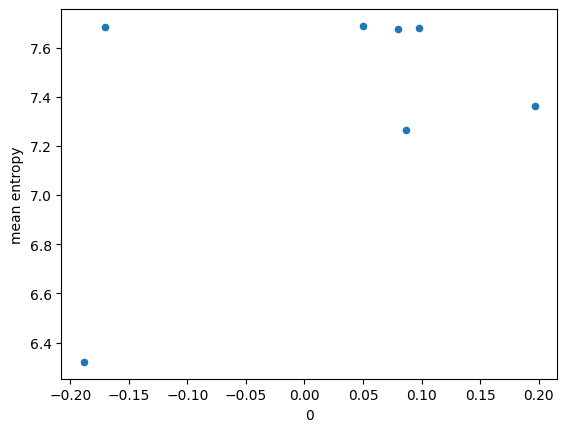

In [52]:
merged.plot.scatter(0, 'mean entropy')